**Praktikum 1**

RNN untuk Analisis Sentimen

**Setup**

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

*Langkah 1 - Import Library*

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric): #Mendefinisikan sebuah fungsi bernama plot_graphs dengan dua parameter: history dan metric.
    plt.plot(history.history[metric]) #Memplot data dari metrik yang diberikan
    plt.plot(history.history['val_'+metric], '') #mengambil data validasi
    plt.xlabel("Epochs") #Menentukan label untuk sumbu x pada grafik sebagai "Epochs"
    plt.ylabel(metric) #Menentukan label untuk sumbu y pada grafik sesuai dengan metrik yang diberikan
    plt.legend([metric, 'val_'+metric]) #Menambahkan legenda pada grafik

**Setup Input Pipeline**

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True) #with_info=True mengembalikan informasi tambahan tentang dataset, dan as_supervised=True memuat dataset dalam format pasangan data dan label.
train_dataset, test_dataset = dataset['train'], dataset['test'] #Memisahkan dataset menjadi dua bagian: data latih (train_dataset) dan data uji (test_dataset) menggunakan akses ke kunci 'train' dan 'test' di objek dataset.

train_dataset.element_spec #Menampilkan spesifikasi elemen dari dataset latih, yaitu tipe data dan struktur dari setiap elemen dalam dataset.

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy()) #Mencetak teks
  print('label: ', label.numpy()) #Mencetak label

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [5]:
BUFFER_SIZE = 10000 #Menentukan ukuran buffer #Buffer ini akan digunakan untuk mengambil sampel secara acak dari dataset.
BATCH_SIZE = 64 #Menentukan ukuran batch

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) #Mengambil dataset latih, melakukan pengacakan dengan ukuran buffer sebesar BUFFER_SIZE, membagi dataset menjadi batch dengan ukuran BATCH_SIZE, dan mengoptimalkan prefetching menggunakan tf.data.AUTOTUNE.
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) #Memanggil batch pada dataset uji dengan ukuran BATCH_SIZE dan mengoptimalkan prefetching menggunakan tf.data.AUTOTUNE.

for example, label in train_dataset.take(1):  #Memulai loop yang akan mengambil satu batch (dalam hal ini, satu batch berisi 64 contoh) dari dataset latih pada setiap iterasi.
  print('texts: ', example.numpy()[:3]) #Mencetak tiga label pertama dari contoh dalam batch menggunakan metode .numpy().
  print()
  print('labels: ', label.numpy()[:3]) #Mencetak tiga label pertama dari contoh dalam batch menggunakan metode .numpy().

texts:  [b'Avoid this crap at all costs. Bad script, bad directing, bad acting, bad editing, bad sound, and bad music. Get the idea? This movie tries to be western flavored, it\'s not. It tries to be hard core violent, it\'s not. It tries to present a fresh look at an old genre, it doesn\'t. The actors try there best, and my heart goes out to them. But with such inane material to work with it\'s hard to make something shine. To me this has all of the looks of a "fresh outta film school gonna set the world on fire" first attempt. Freshmen film makers often bite off more that they, or their budget, can chew. The best thing they can do is to take a few steps back, reassess what is possible, and work within their limited budget the next time out.'
 b'i love bad shark movies. i really do. i laugh hysterically at them. and the scifi channel was having a marathon of them, culminating in the premier of their new original picture, hammerhead: shark frenzy. based on the previews, it looked like 

**Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [6]:
VOCAB_SIZE = 1000 #membatasi jumlah kata yang akan dipertimbangkan dalam pemrosesan teks.
encoder = tf.keras.layers.TextVectorization( #mengonversi teks menjadi representasi numerik.
    max_tokens=VOCAB_SIZE) #menentukan jumlah kata yang akan disimpan dalam indeks kosakata.
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20] #Mengambil 20 kata pertama

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example #Mencetak hasil dari encoding yang disimpan dalam variabel 

array([[780,  11, 638, ...,   0,   0,   0],
       [ 10, 116,  84, ...,   0,   0,   0],
       [ 10, 284,   2, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [9]:
for n in range(3): #Memulai loop for yang akan berjalan sebanyak tiga kali, dengan n sebagai variabel iterasi.
  print("Original: ", example[n].numpy()) #Mencetak teks asli dari contoh ke-n menggunakan metode .numpy().
  print("Round-trip: ", " ".join(vocab[encoded_example[n]])) #Mencetak baris kosong untuk memisahkan hasil cetakan.
  print() #Mencetak baris kosong untuk memisahkan hasil cetakan.

Original:  b'Avoid this crap at all costs. Bad script, bad directing, bad acting, bad editing, bad sound, and bad music. Get the idea? This movie tries to be western flavored, it\'s not. It tries to be hard core violent, it\'s not. It tries to present a fresh look at an old genre, it doesn\'t. The actors try there best, and my heart goes out to them. But with such inane material to work with it\'s hard to make something shine. To me this has all of the looks of a "fresh outta film school gonna set the world on fire" first attempt. Freshmen film makers often bite off more that they, or their budget, can chew. The best thing they can do is to take a few steps back, reassess what is possible, and work within their limited budget the next time out.'
Round-trip:  avoid this crap at all [UNK] bad script bad directing bad acting bad editing bad sound and bad music get the idea this movie tries to be [UNK] [UNK] its not it tries to be hard [UNK] [UNK] its not it tries to present a [UNK] look a

**Buat Model**

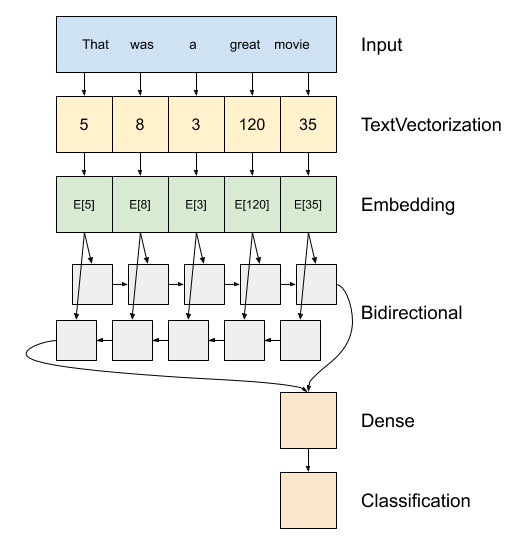

Diagram model dapat dilihat pada gambar diatas

1. Model ini dapat dibuat sebagai tf.keras.Sequential.
2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.
3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.
4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.

- Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.
- Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.
5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

Kode nya adalah sebagai berikut :

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding( #mengubah representasi numerik dari kata-kata ke dalam vektor ruang berdimensi 64.
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), #Menambahkan lapisan LSTM
    tf.keras.layers.Dense(64, activation='relu'), #Menambahkan lapisan Dense dengan 64 unit dan fungsi aktivasi ReLU
    tf.keras.layers.Dense(1) #Menambahkan lapisan Dense dengan 1 unit tanpa fungsi aktivasi
])

Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada Keras RNN guide.

Lapisan penyematan menggunakan masking (uses masking) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [11]:
print([layer.supports_masking for layer in model.layers])
#Mencetak daftar boolean yang menunjukkan apakah setiap lapisan dalam model mendukung masking. 
#Masking digunakan untuk mengatasi panjang urutan yang bervariasi dalam data masukan.

[False, True, True, True, True]


In [12]:
for i, layer in enumerate(model.layers): print(f"Layer {i}: {layer}")
#Kode ini melakukan loop melalui semua lapisan dalam model dan mencetak informasi tentang setiap lapisan, termasuk indeks lapisan dan deskripsi singkatnya. Hal ini membantu dalam memeriksa dan memahami struktur dari model yang telah dibuat.

Layer 0: <keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7e81891cd930>
Layer 1: <keras.src.layers.core.embedding.Embedding object at 0x7e818252af50>
Layer 2: <keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7e818a28e950>
Layer 3: <keras.src.layers.core.dense.Dense object at 0x7e818a28cdc0>
Layer 4: <keras.src.layers.core.dense.Dense object at 0x7e818a28cc10>


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [13]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0]) #Mencetak hasil prediks

1/1 [==============================] - 8s 8s/step
[-0.00665601]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [14]:
# predict on a sample text with padding

padding = "the " * 2000 # teks tambahan untuk pengujian.
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0]) #Mencetak hasil prediksi dari model untuk teks pertama dalam array. 

1/1 [==============================] - 0s 62ms/step
[-0.00665601]


Compile model Keras untuk mengonfigurasi proses pelatihan:

In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
#Kode ini mengonfigurasi model untuk pelatihan. Fungsi loss, optimizer, dan metrik akurasi ditentukan. Setelah kompilasi, model siap untuk dilatih dengan data.

**Train Model**

In [16]:
history = model.fit(train_dataset, epochs=10,validation_data=test_dataset,validation_steps=30)
#Kode ini melakukan proses pelatihan model menggunakan dataset latih (train_dataset) selama 10 epoch. 

Epoch 1/10
391/391 [==============================] - 50s 102ms/step - loss: 0.6440 - accuracy: 0.5652 - val_loss: 0.4728 - val_accuracy: 0.7812
Epoch 2/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3897 - accuracy: 0.8207 - val_loss: 0.3702 - val_accuracy: 0.8156
Epoch 3/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3403 - accuracy: 0.8504 - val_loss: 0.3365 - val_accuracy: 0.8474
Epoch 4/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3182 - accuracy: 0.8604 - val_loss: 0.3376 - val_accuracy: 0.8599
Epoch 5/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3114 - accuracy: 0.8658 - val_loss: 0.3319 - val_accuracy: 0.8599
Epoch 6/10
391/391 [==============================] - 25s 62ms/step - loss: 0.3061 - accuracy: 0.8688 - val_loss: 0.3230 - val_accuracy: 0.8562
Epoch 7/10
391/391 [==============================] - 25s 62ms/step - loss: 0.3037 - accuracy: 0.8672 - val_loss: 0.3219 - val_accuracy

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
#Kode ini melakukan evaluasi performa model pada dataset uji
#Hasil dari evaluasi tersebut (loss dan akurasi) akan dicetak

391/391 [==============================] - 12s 30ms/step - loss: 0.3189 - accuracy: 0.8497
Test Loss: 0.31893327832221985
Test Accuracy: 0.8497200012207031


(0.0, 0.6613662272691727)

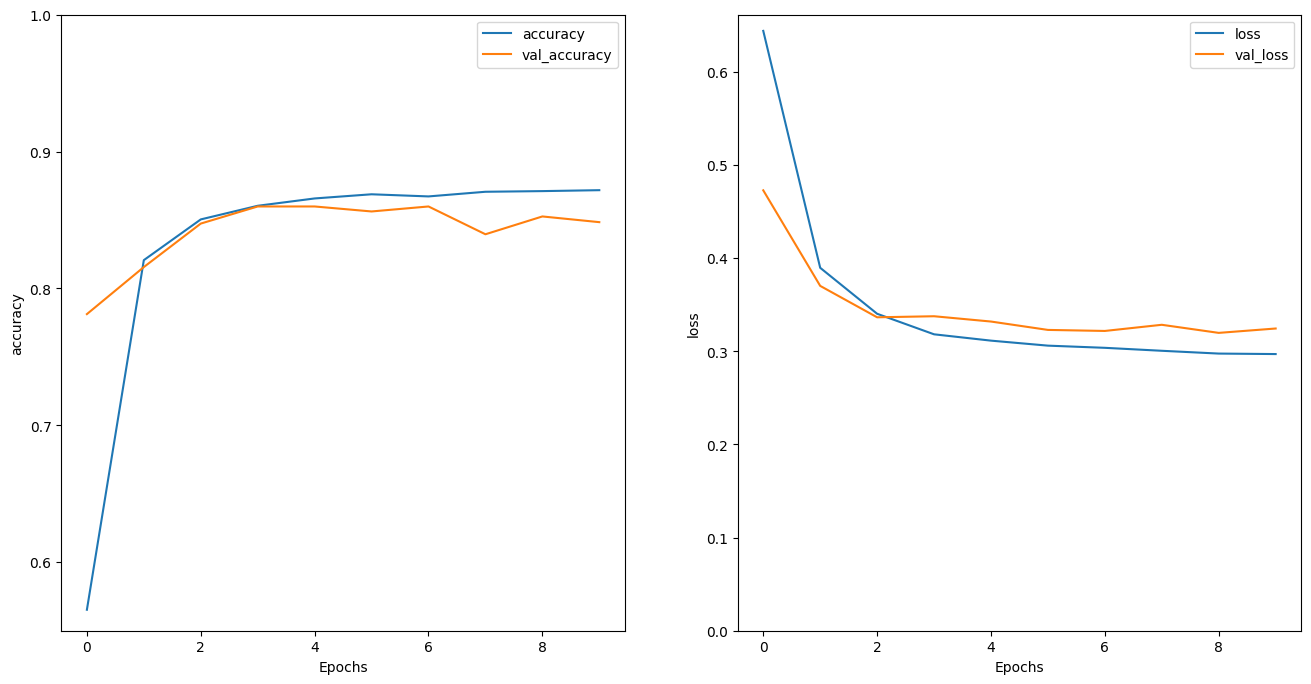

In [18]:
plt.figure(figsize=(16, 8))
#Membuat sebuah gambar (figure) dengan lebar 16 inch dan tinggi 8 inch
#Gambar ini akan menampung dua plot.
plt.subplot(1, 2, 1) #subplot pertama
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2) #subplot kedua
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:
Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [19]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
#Mendefinisikan sebuah variabel sample_text yang berisi teks sampel untuk melakukan prediksi sentimen
#Teks ini memberikan ulasan positif tentang sebuah film.
predictions = model.predict(np.array([sample_text])) #melakukan prediksi sentimen terhadap teks sampel yang telah didefinisikan sebelumnya
print(predictions[0]) #Mencetak hasil prediksi dari model

1/1 [==============================] - 2s 2s/step
[0.5244639]


**Stack two or more LSTM layers**

Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :

- Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.
- Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

Berikut adalah alur informasi dengan return_sequences=True:

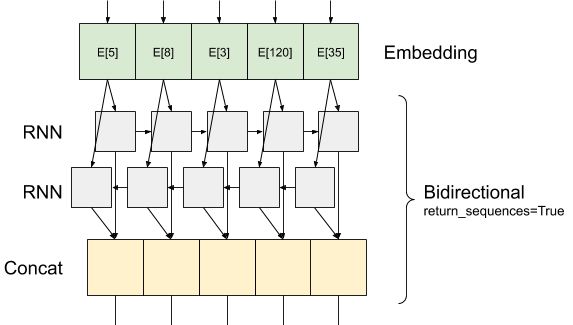

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [20]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'), #Menambahkan lapisan Dense dengan 64 unit dan fungsi aktivasi ReLU
    tf.keras.layers.Dropout(0.5), #Menambahkan lapisan dropout untuk mengurangi overfitting
    tf.keras.layers.Dense(1) #Menambahkan lapisan Dense dengan 1 unit tanpa fungsi aktivasi
])

Kode ini mendefinisikan sebuah model neural network dengan berbagai lapisan, termasuk lapisan embedding, dua lapisan LSTM bidireksional, lapisan Dense tersembunyi, lapisan dropout, dan lapisan output. Model ini dirancang untuk melakukan klasifikasi sentimen pada data teks.

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #model akan mengeluarkan logits sebagai output.
              optimizer=tf.keras.optimizers.Adam(1e-4),
              #Menentukan optimizer yang akan digunakan selama pelatihan.
              #digunakan optimizer Adam dengan learning rate sebesar 1e-4 (0.0001).
              metrics=['accuracy']) #mengevaluasi performa model

In [22]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)
#Kode ini melakukan proses pelatihan model menggunakan dataset latih (train_dataset) selama 10 epoch

Epoch 1/10
391/391 [==============================] - 75s 150ms/step - loss: 0.6276 - accuracy: 0.5889 - val_loss: 0.4461 - val_accuracy: 0.7990
Epoch 2/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3977 - accuracy: 0.8256 - val_loss: 0.3620 - val_accuracy: 0.8453
Epoch 3/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3460 - accuracy: 0.8502 - val_loss: 0.3445 - val_accuracy: 0.8370
Epoch 4/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3253 - accuracy: 0.8601 - val_loss: 0.3252 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3160 - accuracy: 0.8642 - val_loss: 0.3196 - val_accuracy: 0.8594
Epoch 6/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3105 - accuracy: 0.8664 - val_loss: 0.3257 - val_accuracy: 0.8589
Epoch 7/10
391/391 [==============================] - 45s 113ms/step - loss: 0.3065 - accuracy: 0.8684 - val_loss: 0.3178 - val_ac

In [23]:
test_loss, test_acc = model.evaluate(test_dataset) #melakukan evaluasi pada dataset uji 

print('Test Loss:', test_loss) #Mencetak nilai loss
print('Test Accuracy:', test_acc) #Mencetak nilai akurasi 

391/391 [==============================] - 20s 50ms/step - loss: 0.3219 - accuracy: 0.8619
Test Loss: 0.3219066262245178
Test Accuracy: 0.8618800044059753


In [24]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')
#Mendefinisikan sebuah variabel sample_text yang berisi teks sampel untuk melakukan prediksi sentimen. 
#Teks ini memberikan ulasan negatif tentang sebuah film.
predictions = model.predict(np.array([sample_text])) #melakukan prediksi sentimen terhadap teks sampel yang telah didefinisikan sebelumnya
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.7399206]]


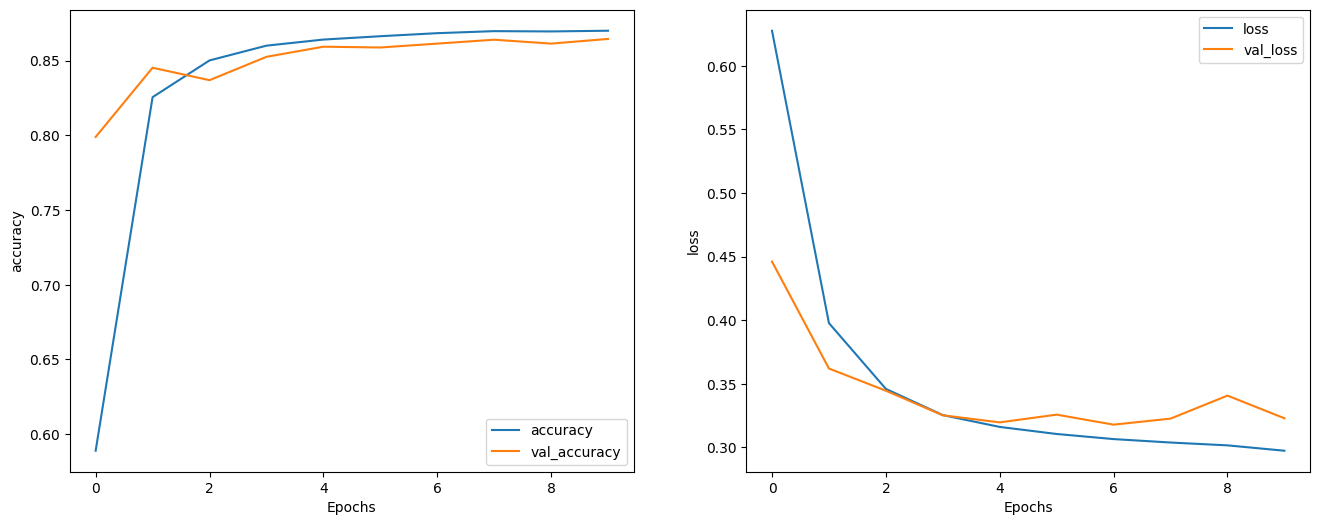

In [25]:
plt.figure(figsize=(16, 6)) #Membuat sebuah gambar (figure) untuk menampung dua plot. Gambar ini memiliki lebar 16 inch dan tinggi 6 inch.
plt.subplot(1, 2, 1) #Membagi gambar menjadi dua subplot, dengan subplot pertama memiliki 1 baris dan 2 kolom, dan akan bekerja pada subplot pertama
plot_graphs(history, 'accuracy')
#Memanggil fungsi plot_graphs untuk memplot grafik akurasi dari data latih dan validasi. 
#Grafik ini akan ditampilkan di subplot pertama.
plt.subplot(1, 2, 2) #subplot kedua
plot_graphs(history, 'loss')
#Memanggil fungsi plot_graphs untuk memplot grafik loss dari data latih dan validasi. 
#Grafik ini akan ditampilkan di subplot kedua.

**Catatan**

Informasi menarik lain terkait dengan GRU layers.
Informasi membuat custom RNN --> Keras RNN Guide.